In [ ]:
import torch

Accesing the GPU's

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

Downloading the CIFAR 10 dataset and transform the data(DATA AUGMENTATION) as per above transform function


In [ ]:
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transforms)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [ ]:
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified


Loading the training and testing data in the batch of 64.

In [ ]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
def accuracy_fn(true,pred):
  correct=torch.eq(true,pred).sum().item()
  
  acc=correct/(len(pred))*100
  #print(acc)
  return acc

In [ ]:
import torch.nn as nn

Downloading the RESNET18 model which is pretrained on ImageNet dataset


In [ ]:
import torch
import torchvision.models as models

# Download the ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Print the model architecture
print(resnet18)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model=resnet18
model = model.to(device)

In [ ]:
loss_fn=nn.CrossEntropyLoss()

Different hyper-parameter in the optimizer function

In [ ]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)

In [ ]:
import  matplotlib.pyplot as  plt

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(true=y,
                                 pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_acc


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn
              ):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(true=y,pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_acc

Running the model for 100 epochs

In [ ]:
from numpy import testing
torch.manual_seed(42)
epochs=100
from tqdm.auto import tqdm
from timeit import default_timer as timer
train_time_model_1=timer()
test_acc=0
epochlist=[]
trainacc=[]
testacc=[]
for epoch in tqdm(range(epochs)):
  print(f"epochs{epoch}")
  train=train_step(data_loader=trainloader,
             model=model,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn)
  trainacc.append(train)
  test=test_step(data_loader=testloader,
             model=model,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn)
  testacc.append(test)

  0%|          | 0/100 [00:00<?, ?it/s]

epochs0
Train loss: 1.84236 | Train accuracy: 37.54%
Test loss: 1.75004 | Test accuracy: 53.24%

epochs1
Train loss: 1.23521 | Train accuracy: 56.74%
Test loss: 0.89662 | Test accuracy: 68.20%

epochs2
Train loss: 0.97771 | Train accuracy: 66.05%
Test loss: 0.85513 | Test accuracy: 70.82%

epochs3
Train loss: 0.87902 | Train accuracy: 69.47%
Test loss: 0.81874 | Test accuracy: 72.32%

epochs4
Train loss: 0.82597 | Train accuracy: 71.45%
Test loss: 0.75159 | Test accuracy: 73.99%

epochs5
Train loss: 0.77282 | Train accuracy: 73.36%
Test loss: 0.80495 | Test accuracy: 73.84%

epochs6
Train loss: 0.74653 | Train accuracy: 74.33%
Test loss: 0.69696 | Test accuracy: 75.92%

epochs7
Train loss: 0.70494 | Train accuracy: 75.81%
Test loss: 0.69337 | Test accuracy: 76.08%

epochs8
Train loss: 0.68097 | Train accuracy: 76.46%
Test loss: 0.68762 | Test accuracy: 76.86%

epochs9
Train loss: 0.66225 | Train accuracy: 77.07%
Test loss: 0.66688 | Test accuracy: 77.72%

epochs10
Train loss: 0.65471 |

In [ ]:
# print(trainacc
#       )

[37.54395780051151, 56.74352621483376, 66.0525895140665, 69.46731138107417, 71.44541240409207, 73.35557864450128, 74.33463874680307, 75.80722506393862, 76.46059782608695, 77.07400895140665, 77.37372122762149, 78.22090792838874, 78.57856457800511, 79.00815217391305, 79.06409846547315, 79.67351342710998, 79.85533887468031, 80.49872122762149, 80.35885549872123, 80.47074808184144, 80.94429347826087, 81.2060421994885, 81.45180626598466, 81.5417199488491, 81.72554347826087, 81.65960677749361, 82.17710997442455, 82.1491368286445, 82.24104859335038, 82.340952685422, 82.63666879795396, 82.6946131713555, 82.74056905370844, 82.8684462915601, 82.6386668797954, 83.10621803069054, 82.93638107416879, 83.17615089514067, 83.36197250639387, 83.50383631713555, 83.55578644501279, 83.57776534526855, 83.82552749360613, 83.59375, 83.76358695652173, 83.53980179028133, 84.07528772378517, 83.91144501278772, 84.30506713554988, 84.19717071611254, 84.29707480818415, 84.28908248081841, 84.20316496163683, 84.7406489

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


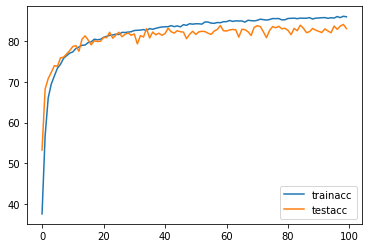

In [ ]:
epochlist=[]
for i in range(100):
  epochlist.append(i)
print(epochlist)
# importing package
import matplotlib.pyplot as plt

# plot lines
plt.plot(epochlist,trainacc, label = "trainacc")
plt.plot(epochlist,testacc, label = "testacc")
plt.legend()
plt.show()